<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html exercisesweek37.do.txt  -->
<!-- dom:TITLE: Exercises week 37 -->

# Exercises week 37
## Implementing gradient descent for Ridge and ordinary Least Squares Regression
### Kjersti Stangeland, Fall 2025

## Learning goals

After having completed these exercises you will have:
1. Your own code for the implementation of the simplest gradient descent approach applied to ordinary least squares (OLS) and Ridge regression

2. Be able to compare the analytical expressions for OLS and Rudge regression with the gradient descent approach

3. Explore the role of the learning rate in the gradient descent approach and the hyperparameter $\lambda$ in Ridge regression

4. Scale the data properly

## Simple one-dimensional second-order polynomial

We start with a very simple function

$$
f(x)= 2-x+5x^2,
$$

defined for $x\in [-2,2]$. You can add noise if you wish. 

We are going to fit this function with a polynomial ansatz. The easiest thing is to set up a second-order polynomial and see if you can fit the above function.
Feel free to play around with higher-order polynomials.

## Exercise 1, scale your data

Before fitting a regression model, it is good practice to normalize or
standardize the features. This ensures all features are on a
comparable scale, which is especially important when using
regularization. Here we will perform standardization, scaling each
feature to have mean 0 and standard deviation 1.

In [6]:
n = 100
x = np.linspace(-2, 2, n)
y = 2 - x + 5*x**2

In [7]:
def polynomial_features(x, p, intercept=False):
    n = len(x)

    if intercept:
        X = np.zeros((n, p + 1))
        X[:, 0] = 1
        for i in range(1, p + 1):
            X[:, i] = x ** i
    else:
        X = np.zeros((n, p))
        for i in range(p):
            X[:, i] = x ** (i + 1)

    return X

In [20]:
X = polynomial_features(x, 3)

### 1a)

Compute the mean and standard deviation of each column (feature) in your design/feature matrix $\boldsymbol{X}$.
Subtract the mean and divide by the standard deviation for each feature.

We will also center the target $\boldsymbol{y}$ to mean $0$. Centering $\boldsymbol{y}$
(and each feature) means the model does not require a separate intercept
term, the data is shifted such that the intercept is effectively 0
. (In practice, one could include an intercept in the model and not
penalize it, but here we simplify by centering.)
Choose $n=100$ data points and set up $\boldsymbol{x}, $\boldsymbol{y}$ and the design matrix $\boldsymbol{X}$.

In [22]:
# Standardize features (zero mean, unit variance for each feature)
X_mean = X.mean(axis=0) # The mean of each column/feature
X_std = X.std(axis=0)
X_std[X_std == 0] = 1  # safeguard to avoid division by zero for constant features
X_norm = (X - X_mean) / X_std

# Center the target to zero mean (optional, to simplify intercept handling)
y_mean = y.mean()
y_centered = y - y_mean

In [21]:
X[0, :]

array([-2.,  4., -8.])

In [23]:
X_norm[0, :]

array([-1.71481604,  2.16997567, -2.56806862])

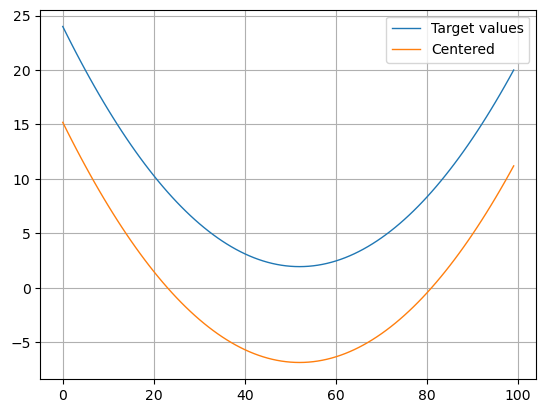

In [25]:
plt.plot(y, linewidth=1, label='Target values')
plt.plot(y_centered, linewidth=1, label='Centered')

plt.legend(loc='upper right')
plt.grid()

Fill in the necessary details.

After this preprocessing, each column of $\boldsymbol{X}_{\mathrm{norm}}$ has mean zero and standard deviation $1$
and $\boldsymbol{y}_{\mathrm{centered}}$ has mean 0. This makes the optimization landscape
nicer and ensures the regularization penalty $\lambda \sum_j
\theta_j^2$ in Ridge regression treats each coefficient fairly (since features are on the
same scale).

In [24]:
# Checking that it was correct
print(f'X_norm mean: {X_norm.mean(axis=0)}')
print()
print(f'X_norm STD: {X_norm.std(axis=0)}')
print()
print(f'y_centered mean: {y_centered.mean()}')

X_norm mean: [ 1.15463195e-16 -1.33226763e-16 -1.86517468e-16]

X_norm STD: [1. 1. 1.]

y_centered mean: 1.4210854715202005e-15


## Exercise 2, calculate the gradients

Find the gradients for OLS and Ridge regression using the mean-squared error as cost/loss function.

## Exercise 3, use the analytical formulae for OLS and Ridge regression to find the optimal paramters $\boldsymbol{\theta}$

In [ ]:
# Set regularization parameter, either a single value or a vector of values
lambdaa = 0.5  # been trying out both small and large numbers

# Analytical form for OLS and Ridge solution: theta_Ridge = (X^T X + lambda * I)^{-1} X^T y and theta_OLS = (X^T X)^{-1} X^T y
I = np.eye(n_features)

X_T = X.T

theta_closed_formRidge = np.linalg.inv((X_T @ X) + (lambdaa * I)) @ X_T @ y 

theta_closed_formOLS = np.linalg.inv(X_T @ X) @ X_T @ y

This computes the Ridge and OLS regression coefficients directly. The identity
matrix $I$ has the same size as $X^T X$. It adds $\lambda$ to the diagonal of $X^T X$ for Ridge regression. We
then invert this matrix and multiply by $X^T y$. The result
for $\boldsymbol{\theta}$  is a NumPy array of shape (n$\_$features,) containing the
fitted parameters $\boldsymbol{\theta}$.

### 3a)

Finalize, in the above code, the OLS and Ridge regression determination of the optimal parameters $\boldsymbol{\theta}$.

In [ ]:
print("Closed-form Ridge coefficients:")
print(theta_closed_formRidge)
print()
print("Closed-form OLS coefficients:")
print(theta_closed_formOLS)

### 3b)

Explore the results as function of different values of the hyperparameter $\lambda$. See for example exercise 4 from week 36.

In [ ]:
lambdas = np.logspace(-5, 5, 20)

theta_closed_formRidge = []
for l in lambdas:
    theta_ridge = np.linalg.inv((X_T @ X) + (l * I)) @ X_T @ y 
    theta_closed_formRidge.append(theta_ridge) 

In [ ]:
plt.figure(figsize=(10, 8))

plt.plot(theta_closed_formOLS, color='black', label='OLS', linewidth=3)

for idx, t in enumerate(theta_closed_formRidge):
    plt.plot(t, linestyle='--', alpha=0.6, label=f'Lambda={lambdas[idx]:.2e}')

plt.xlabel('Feature #')
plt.ylabel('Feature value')
plt.title('Feature Values for OLS and Ridge Regression Coefficients')
plt.legend(loc='upper right')
plt.grid()

## Exercise 4, Implementing the simplest form for gradient descent

Alternatively, we can fit the ridge regression model using gradient
descent. This is useful to visualize the iterative convergence and is
necessary if $n$ and $p$ are so large that the closed-form might be
too slow or memory-intensive. We derive the gradients from the cost
functions defined above. Use the gradients of the Ridge and OLS cost functions with respect to
the parameters  $\boldsymbol{\theta}$ and set up (using the template below) your own gradient descent code for OLS and Ridge regression.

Below is a template code for gradient descent implementation of ridge:

In [ ]:
# Gradient descent parameters, learning rate eta first
eta = 0.1

# Then number of iterations
num_iters = 1000

# Arrays to store history for plotting
cost_history_R = []
cost_history_O = []

# Gradient descent loop
m = n_samples  # number of examples

# Ridge lambda
lamb = 1e-10

# Starting off with zeros for theta
theta_gdOLS = np.zeros(n_features)
theta_gdRidge = np.zeros(n_features)

for t in range(num_iters):
    # Compute prediction error
    error_OLS = X_norm.dot(theta_gdOLS) - y_centered 
    error_Ridge = X_norm.dot(theta_gdRidge) - y_centered

    # Compute cost for OLS and Ridge (MSE + regularization for Ridge) for monitoring
    cost_OLS = np.sum(error_OLS**2)/m
    cost_history_O.append(cost_OLS)
    
    cost_Ridge = (np.sum(error_Ridge**2) + (lamb * np.sum(theta_gdRidge**2)))/m
    cost_history_R.append(cost_Ridge)

    # Compute gradients for OLS and Ridge
    grad_OLS = (2/m) * X_norm.T.dot(error_OLS)
    grad_Ridge = (2/m) * (X_norm.T.dot(error_Ridge) + (2 * lamb * theta_gdRidge))

    # Update parameters theta
    theta_gdOLS -= eta*grad_OLS
    theta_gdRidge -= eta*grad_Ridge

# After the loop, theta contains the fitted coefficients
print("Gradient Descent OLS coefficients:", theta_gdOLS)
print()
print("Gradient Descent Ridge coefficients:", theta_gdRidge)
print()
print('True theta values:', theta_true)

### 4a)

Discuss the results as function of the learning rate parameters and the number of iterations.

__Answer:__

The learning rate is the step size we take when moving to the minimum of the cost function. If the step size is to big, we might 'step over' the minima. If the step size is too small, we might need alot of iterations to get to the minima, i.e. it would be very computationally costly. If the number of iterations is too small we might not get to the minima in the ammount of iterations, and too many iterations would result in a waste of computations because the minima is already found. In the plot below we see that 1000 iterations was too many as the cost function did not become lower after around 20 iterations.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6,4))

ax[0].plot(cost_history_R, label='Ridge')
ax[0].plot(cost_history_O, label='OLS')
ax[0].set_title('Full cost history')

ax[1].plot(cost_history_R[:25], label='Ridge')
ax[1].plot(cost_history_O[:25], label='OLS')
ax[1].set_title('First 25 in cost history')

ax[0].legend()
ax[1].legend()

### 4b)

Try to add a stopping parameter as function of the number iterations. How would you define a stopping criterion?

In [ ]:
# Gradient descent parameters, learning rate eta first
eta = 0.1

# Then number of iterations
num_iters = 1000

# Arrays to store history for plotting
cost_history_R = []
cost_history_O = []

# Gradient descent loop
m = n_samples  # number of examples

# Ridge lambda
lamb = 0.1

# Starting off with zeros for theta
theta_gdOLS = np.zeros(n_features)
theta_gdRidge = np.zeros(n_features) 

# If theta is changed by less than tol -> break loop
tol = 1e-5

for t in range(num_iters):
    # Compute prediction error
    error_OLS = X_norm.dot(theta_gdOLS) - y_centered 
    error_Ridge = X_norm.dot(theta_gdRidge) - y_centered

    # Compute cost for OLS and Ridge (MSE + regularization for Ridge) for monitoring
    cost_OLS = np.sum(error_OLS**2)/m
    cost_history_O.append(cost_OLS)

    cost_Ridge = (np.sum(error_Ridge**2) + lamb * np.sum(theta**2))/m
    cost_history_R.append(cost_Ridge)

    # Compute gradients for OLS and Ridge
    grad_OLS = (2/m) * X_norm.T.dot(error_OLS)
    grad_Ridge = (2/m) * X_norm.T.dot(error_Ridge) + 2 * lamb * theta_gdRidge

    # Update parameters theta
    new_theta_gdOLS = theta_gdOLS - eta*grad_OLS
    new_theta_gdRidge = theta_gdRidge - eta*grad_Ridge

    # Checking if further iterations are necessary
    if np.linalg.norm(new_theta_gdOLS - theta_gdOLS) < tol and np.linalg.norm(new_theta_gdRidge - theta_gdRidge) < tol:
        print(f'Breaking the loop at iteration {t}')
        break

    # Update parameters theta
    theta_gdOLS = new_theta_gdOLS
    theta_gdRidge = new_theta_gdRidge

I added a criterion where the loop is broke if the change in parameters are small, as if a plateau was reached and no further progress was done compared to the previous iteration.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6,4))

ax[0].plot(cost_history_R, label='Ridge')
ax[0].plot(cost_history_O, label='OLS')
ax[0].set_title('Full cost history')

ax[1].plot(cost_history_R[:25], label='Ridge')
ax[1].plot(cost_history_O[:25], label='OLS')
ax[1].set_title('First 25 in cost history')

ax[0].legend()
ax[1].legend()

In [ ]:
# Which method gives the best results?
plt.plot(theta_true, linewidth=1, label='True features')
plt.plot(theta_gdOLS, linestyle='--', label='OLS features')
plt.plot(theta_gdRidge, linestyle='--', label='Ridge features')

plt.legend()
plt.grid()

In [ ]:
plt.plot(theta_true - theta_gdOLS, label='True - OLS')
plt.plot(theta_true - theta_gdRidge, label='True - Ridge')
plt.grid()
plt.legend()
plt.title('Theta difference')

It seems to me that OLS gives the closest results to the true theta values. I played around with different values of lambda and found that it had to be very small in order to not have large differences from true theta. Therefore a bit unclear to me now the point of doing Ridge regression..?

## Exercise 5, Ridge regression and a new Synthetic Dataset

We create a synthetic linear regression dataset with a sparse
underlying relationship. This means we have many features but only a
few of them actually contribute to the target. In our example, we’ll
use 10 features with only 3 non-zero weights in the true model. This
way, the target is generated as a linear combination of a few features
(with known coefficients) plus some random noise. The steps we include are:

Decide on the number of samples and features (e.g. 100 samples, 10 features).
Define the **true** coefficient vector with mostly zeros (for sparsity). For example, we set $\hat{\boldsymbol{\theta}} = [5.0, -3.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0]$, meaning only features 0, 1, and 6 have a real effect on y.

Then we sample feature values for $\boldsymbol{X}$ randomly (e.g. from a normal distribution). We use a normal distribution so features are roughly centered around 0.
Then we compute the target values $y$ using the linear combination $\boldsymbol{X}\hat{\boldsymbol{\theta}}$ and add some noise (to simulate measurement error or unexplained variance).

Below is the code to generate the dataset:

In [4]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(0)

# Define dataset size
n_samples = 100
n_features = 10

# Define true coefficients (sparse linear relationship)
theta_true = np.array([5.0, -3.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0])

# Generate feature matrix X (n_samples x n_features) with random values
X = np.random.randn(n_samples, n_features)  # standard normal distribution

# Generate target values y with a linear combination of X and theta_true, plus noise
noise = 0.5 * np.random.randn(n_samples)    # Gaussian noise
y = X.dot @ theta_true + noise

This code produces a dataset where only features 0, 1, and 6
significantly influence $\boldsymbol{y}$. The rest of the features have zero true
coefficient. For example, feature 0 has
a true weight of 5.0, feature 1 has -3.0, and feature 6 has 2.0, so
the expected relationship is:

$$
y \approx 5 \times x_0 \;-\; 3 \times x_1 \;+\; 2 \times x_6 \;+\; \text{noise}.
$$

You can remove the noise if you wish to. 

Try to fit the above data set using OLS and Ridge regression with the analytical expressions and your own gradient descent codes.

If everything worked correctly, the learned coefficients should be
close to the true values [5.0, -3.0, 0.0, …, 2.0, …] that we used to
generate the data. Keep in mind that due to regularization and noise,
the learned values will not exactly equal the true ones, but they
should be in the same ballpark.  Which method (OLS or Ridge) gives the best results?